In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors

from scipy.special import logsumexp
from scipy import linalg
from scipy.sparse.linalg import eigs

Аналогчино задаче про кривой кубок (стр 54 в Дурбине):

In [55]:

#матрица переходов между скрытыми состояниями:
A =  np.array([[0.99, 0.01], [0.05, 0.95]])
 

m = A.shape[0] #число скрытых состояний

n = 4 #Вариантов открытых состояний 

#Матрица эмиссий - открытые состояния из скрытых:
B = np.ones((m, n))
B[0, :] = B[0, :]/n
B[1, 0] = 0.15
B[1, 1] = 0.15
B[1, 2] = 0.35 #повышення вероятность для G и C на островке  
B[1, 3] = 0.35

#Начальное распределение состояний:
p = np.ones(m)/m
#p = np.array([1, 0])

Генератор 

In [56]:

#L - аргумент для задания длины цепочки состояний
def generate_sample(A, B, p0, L=300):
    n = B.shape[1]
    m = A.shape[0]
    hidden_seq = np.zeros(L, dtype = int)
    open_seq = np.zeros(L, dtype = int)
    
    hidden_seq[0] = np.random.choice(m, p =p0)
    
    open_seq[0] = np.random.choice(n, p =B[hidden_seq[0]])
    for i in range(1, L):
        hidden_seq[i] = np.random.choice(m, p = A[hidden_seq[i-1]])
     
        open_seq[i] =  np.random.choice(n, p =B[hidden_seq[i]])
    
    return hidden_seq, open_seq

In [57]:
hidden_seq, open_seq = generate_sample(A, B, p)
initvalue = hidden_seq[0]
 

In [58]:
def Viterbi(A, B, p0, open_seq):
    
    L = len(open_seq)   
    m = A.shape[0]
    v = np.zeros((m, L))
    ptr = np.zeros((L, m)) #
    
    #Вроде мы знаем начальное распределение типов кубика, а не идет от определенного состояния 
    v[:, 0] = np.log(p0) + np.log(B[:, open_seq[0]]) 
    #v[initvalue, 0] = 1 #p0#1#np.log(np.multiply(p0, B[:, open_seq[0]]))
    #v[:, 0] =  p0
    for i in range(1, L):
        #вероятность эмиссионная + переход
        v[:,i] = np.log(B[:, open_seq[i]]) + np.max(v[:,i-1].T + np.log(A.T), axis = 1) #check A 
        ptr[i, :] = np.argmax(v[:,i-1].T + np.log(A.T), axis = 1) #check axis 
  
    hidden_seq = np.zeros(L, dtype=int)
    hidden_seq[-1] = np.argmax(v[:, -1])
    for i in range(L - 1, 0, -1):
        hidden_seq[i - 1] = ptr[i, hidden_seq[i]]
     
    return hidden_seq

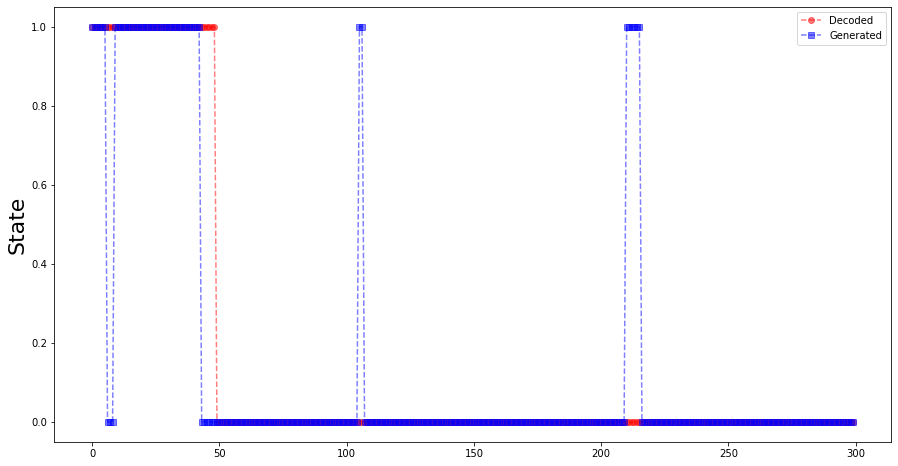

In [60]:
#A =  np.array([[0.8, 0.2], [0.1, 0.9]])
decoded = Viterbi(A, B, p, open_seq)
     
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
 
plt.plot(decoded, "o--", alpha = 0.5, c="r", label =  "Decoded")
plt.plot(hidden_seq, "s--", alpha = 0.5, c = "b", label = "Generated")

plt.ylabel(r"State", fontsize=22)

plt.legend()

Для Витрби вполне нормально,не чувстсовать "короткие" зоны смены состояний 

In [20]:
def forward(A, B, p0, open_seq):
    m = A.shape[0]
    T = len(open_seq)
    f = np.zeros((T + 1, m))
    f[0, :] = p0
    log_px = 0.
    for t in range(1, T + 1):
        f[t] = B[:,  open_seq[t - 1]] * np.dot(f[t - 1], A)
        pt = f[t].sum()
        f[t] = f[t]/pt #шкалируем для сохранения точности 
        log_px += np.log(pt) 
        #print(log_px)
    return f, log_px
 

In [21]:
def backward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    b = np.zeros((T + 1, m))
    b[T, :] = 1
    log_px = 0.
    for t in range(T, 0, -1):
        b[t - 1] = np.dot(A, b[t] * B[:, open_seq[t - 1]])
        pt = b[t - 1].sum()
        b[t - 1]  = b[t - 1] / pt #шкалируем для сохранения точности 
        log_px += np.log(pt)
        #print(log_px)
    log_px += np.log(np.sum( b[0, :]*p0 ) )
    return b, log_px    

-412.3529084635997 -412.35290846359993


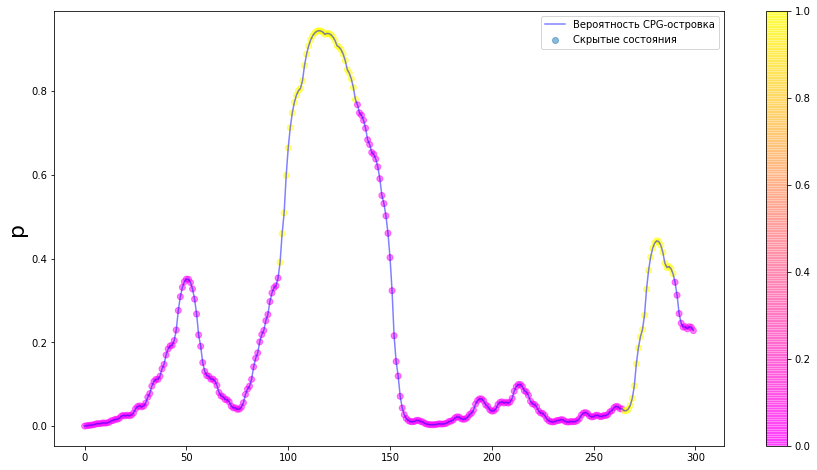

In [22]:
f, fdecoded = forward(A, B, p, open_seq)

b, bdecoded = backward(A, B, p, open_seq)
print(fdecoded, bdecoded)
       
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
gamma = f[:-1, :] * b[:-1, :]

gamma /= np.sum(gamma, axis=1, keepdims=True)
plt.scatter(np.arange(len(hidden_seq)), gamma[:,1],  alpha = 0.5, c=hidden_seq, label =  "Скрытые состояния", cmap = "spring")

plt.plot(np.arange(len(hidden_seq)),gamma [:,1], "-", alpha = 0.5, c = "b", label = "Вероятность CPG-островка")


plt.ylabel(r"p", fontsize=22)

plt.legend()

plt.colorbar()

Можно выполнить проверку, что функции правдоподобия, полученные в forward и backward  совпадают. Я считаю логарифмическую, так как это позволяет не потерять в точности 

In [10]:
fdecoded, bdecoded

(-412.3529084635997, -412.35290846359993)

Тестовая последовательность 

In [64]:
f = open("sequence.txt")
s = f.readline()

Nuc = { "a" : 0, "t" :1, "g" :2 , "c" :3 }

In [65]:
open_genome = np.zeros(len(s), dtype = int)

for i in range(len(s)):
    open_genome[i] = Nuc[s[i]]

Forward-Backward: 

-459.76161965360257 -459.7616196536025


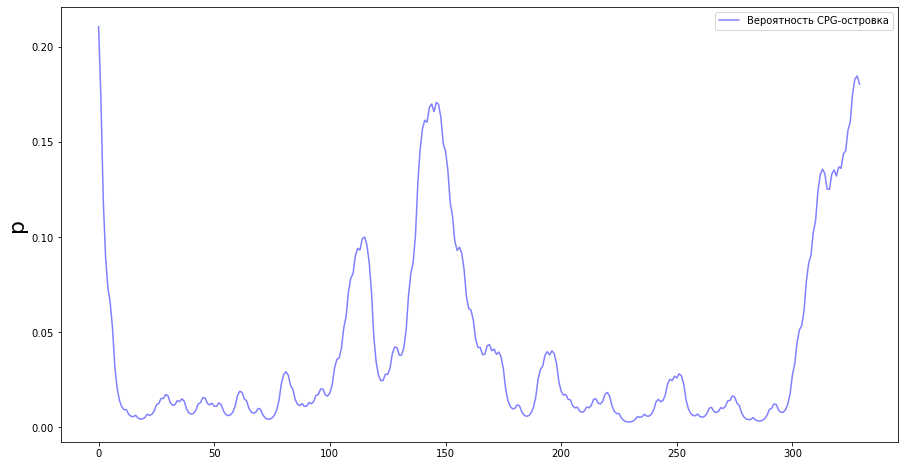

In [67]:
f, fdecoded = forward(A, B, p, open_genome)
b, bdecoded = backward(A, B, p, open_genome)
print(fdecoded, bdecoded)
       
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
gamma = f[:-1, :] * b[:-1, :]

gamma /= np.sum(gamma, axis=1, keepdims=True)

plt.plot(np.arange(len(open_genome)),gamma [:,1], "-", alpha = 0.5, c = "b", label = "Вероятность CPG-островка")


plt.ylabel(r"p", fontsize=22)

plt.legend()
 